In [7]:
from __future__ import annotations
from typing import Any, Dict, List, Tuple
import requests

import os
from datetime import datetime, timezone
import requests_cache
from retry_requests import retry
import openmeteo_requests

from PIL import Image, ImageDraw, ImageFont
from fontHelper import STMSFont

fontPath = "fonts"
FONTS = {
    8 : STMSFont.from_cpp(os.path.join(fontPath,"font8.cpp"), hgap=1),
    12 : STMSFont.from_cpp(os.path.join(fontPath,"font12.cpp"), hgap=1),
    16 : STMSFont.from_cpp(os.path.join(fontPath,"font16.cpp"), hgap=1),
    20 : STMSFont.from_cpp(os.path.join(fontPath,"font20.cpp"), hgap=1),
    24 : STMSFont.from_cpp(os.path.join(fontPath,"font24.cpp"), hgap=1)
}

# -------------------- API SETUP --------------------
cache_session = requests_cache.CachedSession("cache/http_cache", expire_after=600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 51.4552,
    "longitude": -2.5966,
    "daily": [
        "temperature_2m_mean",
        "sunrise",
        "sunset",
        "weather_code",
        "temperature_2m_min",
        "temperature_2m_max",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "daylight_duration",
        "apparent_temperature_mean",
    ],
    "hourly": [
        "weather_code",
        "temperature_2m",
        "apparent_temperature",
        "precipitation_probability",
        "relative_humidity_2m",
        "wind_direction_10m",
        "wind_speed_10m",
        "rain",
        "is_day",
    ],
    "current": [
        "temperature_2m",
        "relative_humidity_2m",
        "apparent_temperature",
        "is_day",
        "precipitation",
        "weather_code",
        "wind_speed_10m",
        "wind_direction_10m",
        "wind_gusts_10m",
        "rain"
    ],
    "timezone": "auto",
    "forecast_days": 3,
}

responses = openmeteo.weather_api(url, params=params)
response = responses[0]


# -------------------- HELPERS --------------------
def _ts_to_dt_utc(ts_seconds: int, utc_offset_seconds: int) -> datetime:
    """
    Convert epoch-seconds + offset into a tz-aware UTC datetime.
    We keep timezone.utc for consistent comparisons/sorting, but the time is shifted
    by the location's UTC offset so it matches the API timezone selection.
    """
    return datetime.fromtimestamp(ts_seconds + utc_offset_seconds, tz=timezone.utc)

def build_current_frame(response) -> dict:
    """
    Build a single dict for the current conditions, using a similar key layout
    to hourly frames, plus extra current-only fields.
    """
    current = response.Current()
    off = response.UtcOffsetSeconds()

    # Order matches your "current" request list
    temperature = current.Variables(0).Value()
    humidity = current.Variables(1).Value()
    feels_like = current.Variables(2).Value()
    is_day = current.Variables(3).Value()
    precipitation = current.Variables(4).Value()
    weather_code = current.Variables(5).Value()
    wind_speed = current.Variables(6).Value()
    wind_direction = current.Variables(7).Value()
    wind_gusts = current.Variables(8).Value()
    rain = current.Variables(9).Value()

    # current.Time() is epoch seconds (same style as hourly.Time()) in this client
    time_dt = _ts_to_dt_utc(current.Time(), off)

    # Build a "compatible" frame:
    # - hourly has "rain_probability" and "rain"
    # - current has "precipitation" (we map it into rain for compatibility)
    return {
        "time": time_dt,
        "weather_code": int(weather_code),
        "temperature": float(temperature),
        "feels_like": float(feels_like),
        "rain_probability": None,          # not provided in "current"
        "humidity": float(humidity),
        "wind_direction": float(wind_direction),
        "wind_speed": float(wind_speed),
        "rain": float(rain),      # mapped for compatibility

        # current-only extras (optional but useful)
        "precipitation": float(precipitation),
        "is_day": bool(is_day),
        "wind_gusts": float(wind_gusts),
        "frame_type": "current",
    }


def build_hourly_frames(response) -> list[dict]:
    """
    Build a list of dict frames, one per hour, using plain Python lists (no pandas).
    """
    hourly = response.Hourly()
    off = response.UtcOffsetSeconds()

    # Convert each requested variable into a Python list
    # IMPORTANT: must match the order in params["hourly"]
    weather_code = hourly.Variables(0).ValuesAsNumpy().tolist()
    temperature = hourly.Variables(1).ValuesAsNumpy().tolist()
    feels_like = hourly.Variables(2).ValuesAsNumpy().tolist()
    rain_probability = hourly.Variables(3).ValuesAsNumpy().tolist()
    humidity = hourly.Variables(4).ValuesAsNumpy().tolist()
    wind_direction = hourly.Variables(5).ValuesAsNumpy().tolist()
    wind_speed = hourly.Variables(6).ValuesAsNumpy().tolist()
    rain = hourly.Variables(7).ValuesAsNumpy().tolist()
    is_day = hourly.Variables(8).ValuesAsNumpy().tolist()

    start_ts = hourly.Time()
    interval_s = hourly.Interval()
    count = len(weather_code)

    frames: list[dict] = []
    for i in range(count):
        t = _ts_to_dt_utc(start_ts + i * interval_s, off)

        frames.append(
            {
                "time": t,
                "weather_code": int(weather_code[i]),
                "temperature": float(temperature[i]),
                "feels_like": float(feels_like[i]),
                "rain_probability": float(rain_probability[i]),
                "humidity": float(humidity[i]),
                "wind_direction": float(wind_direction[i]),
                "wind_speed": float(wind_speed[i]),
                "rain": float(rain[i]),
                "is_day": bool(is_day[i]),
                "frame_type": "hourly",
                
            }
        )

    return frames


def next_x_hours(frames: list[dict], x: int, *, from_now: bool = True) -> list[dict]:
    """
    Return the next x frames. If from_now=True, start at the first frame with time >= now.
    Note: frames are tz-aware UTC datetimes (shifted by API offset).
    """
    if x <= 0:
        return []

    if not from_now:
        return frames[:x]

    now = datetime.now(timezone.utc)
    out = []
    for f in frames:
        if f["time"] >= now:
            out.append(f)
            if len(out) >= x:
                break
    return out

def build_daily_frames(response) -> list[dict]:
    """
    params["daily"]:
      [
        "temperature_2m_mean",
        "sunrise",
        "sunset",
        "weather_code",
        "temperature_2m_min",
        "temperature_2m_max",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "daylight_duration",
        "apparent_temperature_mean",
      ]
    """

    def as_list(v):
        """
        Normalize openmeteo_requests ValuesAsNumpy() outputs into a Python list.

        Handles:
        - numpy arrays -> .tolist()
        - python lists/tuples
        - scalars (int/float) -> [scalar]
        - other iterables
        """
        if v is None:
            return []
        if hasattr(v, "tolist"):  # numpy-like
            return v.tolist()
        if isinstance(v, (list, tuple)):
            return list(v)
        # If it's an iterable that's not a string/bytes, try list(...)
        if hasattr(v, "__iter__") and not isinstance(v, (str, bytes)):
            return list(v)
        # scalar
        return [v]

    daily = response.Daily()
    off = response.UtcOffsetSeconds()
    # Extract variables (normalized to plain lists)
    temp_mean = as_list(daily.Variables(0).ValuesAsNumpy())
    sunrise_ts = as_list(daily.Variables(1).ValuesInt64AsNumpy())
    sunset_ts = as_list(daily.Variables(2).ValuesInt64AsNumpy())
    weather_code = as_list(daily.Variables(3).ValuesAsNumpy())
    temp_min = as_list(daily.Variables(4).ValuesAsNumpy())
    temp_max = as_list(daily.Variables(5).ValuesAsNumpy())
    feels_like_max = as_list(daily.Variables(6).ValuesAsNumpy())
    feels_like_min = as_list(daily.Variables(7).ValuesAsNumpy())
    daylight = as_list(daily.Variables(8).ValuesAsNumpy())
    feels_like_mean = as_list(daily.Variables(9).ValuesAsNumpy())

    # Time axis
    start_ts = int(daily.Time())
    interval_s = int(daily.Interval())  # typically 86400

    # Determine how many days we can safely build (today + tomorrow)
    n = min(2, len(weather_code), len(temp_mean), len(temp_min), len(temp_max))
    if n <= 0:
        return []

    frames: list[dict] = []
    for i in range(n):
        date_dt = datetime.fromtimestamp(start_ts + i * interval_s + off, tz=timezone.utc)

        # sunrise/sunset may come back as ints or floats (epoch seconds)
        sr = sunrise_ts[i] if i < len(sunrise_ts) else None
        ss = sunset_ts[i] if i < len(sunset_ts) else None

        frames.append(
            {
                "date": date_dt,
                "weather_code": int(weather_code[i]) if i < len(weather_code) else None,
                "temp_mean": float(temp_mean[i]) if i < len(temp_mean) else None,
                "temp_min": float(temp_min[i]) if i < len(temp_min) else None,
                "temp_max": float(temp_max[i]) if i < len(temp_max) else None,
                "feels_like_mean": float(feels_like_mean[i]) if i < len(feels_like_mean) else None,
                "feels_like_min": float(feels_like_min[i]) if i < len(feels_like_min) else None,
                "feels_like_max": float(feels_like_max[i]) if i < len(feels_like_max) else None,
                "sunrise": datetime.fromtimestamp(int(sr) + off, tz=timezone.utc) if sr is not None else None,
                "sunset": datetime.fromtimestamp(int(ss) + off, tz=timezone.utc) if ss is not None else None,
                "daylight_seconds": int(daylight[i]) if i < len(daylight) else None,
                "frame_type": "daily",
            }
        )

    return frames


# -------------------- BUILD + MERGE --------------------
current_frame = build_current_frame(response)
hourly_frames = build_hourly_frames(response)

all_frames = [current_frame] + hourly_frames
next_hours = next_x_hours(hourly_frames, 12, from_now=True)

days_frames = build_daily_frames(response)

# print("\nCURRENT FRAME:")
# print(current_frame)

# print("\nNEXT 12 HOURLY FRAMES:")
# for f in next_hours:
#     print(f)

# print("\nALL FRAMES (CURRENT + FULL HOURLY):")
# print(f"Total frames: {len(all_frames)}")


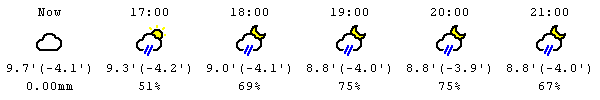

In [8]:
def render_weather_frame(data, width, height, fontSize, weather_icon_index=0):
    """
    data = {
        "label": ["Now", "8.9° (-2.1°)", "0.20mm"],
        "weather_icon": "icons/night_showers.png"
    }

    Returns: PIL.Image in RGB
    """
    font = FONTS[fontSize]

    # RGB canvas (white background)
    img = Image.new("RGB", (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    labels = data.get("label", [])
    icon_path = data.get("weather_icon")

    # Load icon (RGBA, pixel-perfect)
    icon = None
    if icon_path:
        icon = Image.open(icon_path).convert("RGBA")

    # Build render order: insert icon AFTER labels[weather_icon_index]
    items = []
    for i, text in enumerate(labels):
        items.append(("text", text))
        if icon is not None and i == weather_icon_index:
            items.append(("icon", icon))

    # If index is beyond labels, append icon at the end
    if icon is not None and (len(labels) == 0 or weather_icon_index >= len(labels)):
        items.append(("icon", icon))

    # Measure sizes
    widths = []
    heights = []
    for kind, value in items:
        if kind == "text":
            bbox = draw.textbbox((0, 0), value, font=font)
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
        else:
            w = value.width
            h = value.height
        widths.append(w)
        heights.append(h)

    # Spacing between items
    spacing = max(1, fontSize // 2)

    total_height = sum(heights) + spacing * (len(heights) - 1)
    y = (height - total_height) // 2

    # Render items
    for (kind, value), w, h in zip(items, widths, heights):
        x = (width - w) // 2

        if kind == "text":
            draw.text((x, y), value, fill=(0, 0, 0), font=font)
        else:
            # Paste RGBA icon using its alpha channel
            img.paste(value, (x, y), value)

        y += h + spacing

    return img

def map_wmo_to_icon(
    code: int,
    *,
    is_day: bool,
    windy: bool = False,
) -> str:
    """
    Map Open-Meteo WMO weather code to icon filename.
    """

    # ---- Clear ----
    if code == 0:
        return "icons/sunny.png" if is_day else "icons/night.png"

    # ---- Mainly clear / partly cloudy ----
    if code in (1, 2):
        return "icons/cloudy_day.png" if is_day else "icons/night_clouds.png"

    # ---- Overcast ----
    if code == 3:
        return "icons/cloud.png"

    # ---- Fog ----
    if code in (45, 48):
        if is_day:
            return "icons/day_cloud_fog.png"
        else:
            return "icons/night_clouds_fog.png"

    # ---- Drizzle / light rain ----
    if 51 <= code <= 55:
        if is_day:
            return "icons/sunny_light_rain.png"
        else:
            return "icons/night_showers.png"

    # ---- Freezing drizzle ----
    if 56 <= code <= 57:
        return "icons/mix_rain_snow.png"

    # ---- Rain ----
    if 61 <= code <= 63:
        return "icons/light_rain.png"

    if 64 <= code <= 65:
        return "icons/heavy_rain.png"

    # ---- Freezing rain ----
    if 66 <= code <= 67:
        return "icons/mix_rain_snow.png"

    # ---- Snow ----
    if 71 <= code <= 75 or code == 77:
        if is_day:
            return "icons/sunny_snow.png"
        else:
            return "icons/night_snow.png"

    # ---- Rain showers ----
    if 80 <= code <= 82:
        return "icons/showers.png" if is_day else "icons/night_showers.png"

    # ---- Snow showers ----
    if 85 <= code <= 86:
        return "icons/snow.png"

    # ---- Thunderstorm ----
    if code == 95:
        return "icons/thunderstorm.png"

    if 96 <= code <= 99:
        return "icons/rainy-thunderstorm.png"

    # ---- Wind (only if nothing else matched) ----
    if windy:
        return "icons/wind gusts.png"

    # ---- Fallback ----
    return "icons/cloud.png"

StrungStrings = []
for item in [current_frame] + next_x_hours(all_frames, 12, from_now=True):
    string = []


    if item["frame_type"] == "current":
        string.append("Now")
        string.append(f"{item["temperature"]:.1f}'({item["feels_like"]-item["temperature"]:.1f}')")
        string.append(f"{item["rain"]:.2f}mm")
    else:
        string.append(item["time"].strftime("%H:%M"))
        string.append(f"{item["temperature"]:.1f}'({item["feels_like"]-item["temperature"]:.1f}')")
        string.append(f"{item["rain_probability"]:.0f}%")

    StrungStrings.append({
        "label" : string,
        "weather_icon" : map_wmo_to_icon(item["weather_code"], is_day=item["is_day"])
    })

def Render_weather(StrungStrings, width, height, hours, fontSize = 12, WeatherIconIndex = 0):

    sizeperframe = (width//hours,height)
    image = Image.new("RGB", (width, height), (255,255,255))

    for i in range(hours):
        cell = render_weather_frame(StrungStrings[i],sizeperframe[0],sizeperframe[1],fontSize,WeatherIconIndex)

        image.paste(cell, (i*sizeperframe[0],0))

    return image

Render_weather(StrungStrings, 600, 100,6)


In [12]:
# Sun: 8:30 - 22:00 for 13h 30m | Temp: H:9° L:5° A:8.1°

def render_daylight_frame(data, template, width, height, fontSize):
    """
    Renders a single RGB image using a template string with placeholders.

    Placeholders supported (as per your example):
      <sunrise> <sunset> <daylight>
      <tempHigh> <tempLow> <tempAvg>
      <feelsTempHigh> <feelsTempLow> <feelsTempAvg>

    Notes:
    - sunrise/sunset can be datetime; rendered as HH:MM
    - daylight_seconds rendered as HhMm (e.g., 9h13m)
    - temps rendered as integers with degree symbol
    - Text is word-wrapped to fit width, and vertically centered.
    """

    font = FONTS[fontSize]

    # --- Helpers (kept inside for "single function" feel) ---
    def fmt_time(dt):
        if dt is None:
            return "--:--"
        try:
            return dt.strftime("%H:%M")
        except Exception:
            return str(dt)

    def fmt_daylight(sec):
        if sec is None:
            return "--"
        try:
            sec = int(sec)
        except Exception:
            return str(sec)
        h = sec // 3600
        m = (sec % 3600) // 60
        return f"{h}h{m:02d}m"

    def fmt_temp(v):
        if v is None:
            return "--"
        try:
            return f"{int(round(float(v)))}"
        except Exception:
            return str(v)

    def text_w(draw, s):
        bbox = draw.textbbox((0, 0), s, font=font)
        return bbox[2] - bbox[0]

    def text_h(draw, s):
        bbox = draw.textbbox((0, 0), s, font=font)
        return bbox[3] - bbox[1]

    # --- Map data -> template fields ---
    replacements = {
        "<sunrise>": fmt_time(data.get("sunrise")),
        "<sunset>": fmt_time(data.get("sunset")),
        "<daylight>": fmt_daylight(data.get("daylight_seconds")),
        "<tempHigh>": fmt_temp(data.get("temp_max")),
        "<tempLow>": fmt_temp(data.get("temp_min")),
        "<tempAvg>": fmt_temp(data.get("temp_mean")),
        "<feelsTempHigh>": fmt_temp(data.get("feels_like_max")),
        "<feelsTempLow>": fmt_temp(data.get("feels_like_min")),
        "<feelsTempAvg>": fmt_temp(data.get("feels_like_mean")),
    }

    text = template
    for k, v in replacements.items():
        text = text.replace(k, v)

    # --- Create RGB canvas ---
    img = Image.new("RGB", (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    # --- Word wrap to fit width ---
    max_w = max(1, width - 4)  # small padding
    words = text.split(" ")
    lines = []
    cur = ""

    for w in words:
        candidate = w if cur == "" else (cur + " " + w)
        if text_w(draw, candidate) <= max_w:
            cur = candidate
        else:
            if cur:
                lines.append(cur)
            # If a single "word" is too long, hard-split it
            if text_w(draw, w) <= max_w:
                cur = w
            else:
                chunk = ""
                for ch in w:
                    cand2 = chunk + ch
                    if text_w(draw, cand2) <= max_w:
                        chunk = cand2
                    else:
                        if chunk:
                            lines.append(chunk)
                        chunk = ch
                cur = chunk

    if cur:
        lines.append(cur)

    # --- Vertical centering of all lines ---
    line_spacing = max(1, fontSize // 3)
    line_heights = [text_h(draw, ln) for ln in lines]
    total_h = sum(line_heights) + line_spacing * (len(lines) - 1)

    y = (height - total_h) // 2

    # --- Draw lines, centered horizontally ---
    for ln, lh in zip(lines, line_heights):
        ln_w = text_w(draw, ln)
        x = (width - ln_w) // 2
        draw.text((x, y), ln, fill=(0, 0, 0), font=font)
        y += lh + line_spacing

    return img

template = "Sun: <sunrise> - <sunset> for <daylight> | Temp: H:<tempHigh>'(<feelsTempHigh>') L:<tempLow>'(<feelsTempLow>') A:<tempAvg>'(<feelsTempAvg>')"
render_daylight_frame(days_frames[0], template, 400, 20, 8)


In [10]:
def render_update_status_frame(dateNow, dateNext, template, width, height, fontSize):
    """
    date: datetime (the last-updated time)
    template example: "Last Updated <lastUpdated> Next at <nextUpdate>"
    Both placeholders render as HH:MM (24h).

    This function renders a single RGB image, centered, word-wrapped if needed.
    Next update is derived as +1 hour from `date`.
    """

    font = FONTS[fontSize]

    # --- Format times as HH:MM ---
    def fmt_hhmm(dt):
        if dt is None:
            return "--:--"
        try:
            return dt.strftime("%H:%M")
        except Exception:
            return str(dt)

    last_updated = fmt_hhmm(dateNow)

    next_dt = None
    if isinstance(dateNow, datetime):
        # Use datetime.replace/minutes logic safely via timestamp arithmetic
        # (works for tz-aware and naive; keeps tzinfo)
        next_dt = dateNow + (dateNow - dateNow)  # placeholder; overwritten below
        next_dt = dateNext

    next_update = fmt_hhmm(next_dt)

    text = template.replace("<lastUpdated>", last_updated).replace("<nextUpdate>", next_update)

    # --- Create RGB canvas ---
    img = Image.new("RGB", (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    # --- Measure helpers (avoid textlength() for STMSFont compatibility) ---
    def text_w(s):
        bbox = draw.textbbox((0, 0), s, font=font)
        return bbox[2] - bbox[0]

    def text_h(s):
        bbox = draw.textbbox((0, 0), s, font=font)
        return bbox[3] - bbox[1]

    # --- Word wrap to fit width ---
    max_w = max(1, width - 4)  # small padding
    words = text.split(" ")
    lines = []
    cur = ""

    for w in words:
        candidate = w if cur == "" else (cur + " " + w)
        if text_w(candidate) <= max_w:
            cur = candidate
        else:
            if cur:
                lines.append(cur)
            # hard-split very long tokens if needed
            if text_w(w) <= max_w:
                cur = w
            else:
                chunk = ""
                for ch in w:
                    cand2 = chunk + ch
                    if text_w(cand2) <= max_w:
                        chunk = cand2
                    else:
                        if chunk:
                            lines.append(chunk)
                        chunk = ch
                cur = chunk

    if cur:
        lines.append(cur)

    # --- Vertical centering ---
    line_spacing = max(1, fontSize // 3)
    heights = [text_h(ln) for ln in lines]
    total_h = sum(heights) + line_spacing * (len(heights) - 1)
    y = (height - total_h) // 2

    # --- Draw centered lines ---
    for ln, lh in zip(lines, heights):
        x = (width - text_w(ln)) // 2
        draw.text((x, y), ln, fill=(0, 0, 0), font=font)
        y += lh + line_spacing

    return img

template = "Last Updated <lastUpdated> Next at <nextUpdate>"
render_update_status_frame(datetime.now(), datetime(2026,2,9,0,10), template, 200, 20, 8)

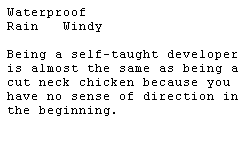

In [11]:
def render_hourly_recommendation_image(
    hourly: List[Dict[str, Any]],
    width: int,
    height: int,
    fontSize: int,
    fun: bool = False,
    fun_timeout_s: float = 1.2,
) -> Image.Image:
    """
    Text-only recommendation widget.

    - hourly: list of hourly frame dicts
    - font: FONTS[fontSize]
    - bbox-only sizing (STMSFont-safe)
    - up to 4 lines
    - optional JokeAPI joke line
    """

    # ---------------- thresholds ----------------
    LOOKAHEAD_FRAMES = 3

    RAIN_MM_THRESHOLD = 0.2
    RAIN_PROB_THRESHOLD = 50

    WIND_LOW_MS = 5.0
    WIND_HIGH_MS = 8.0
    WINDY_MS = 5.0

    # Used ONLY for puffer decision
    COLD_TEMP_C = 8.0
    COLD_FEELS_C = 6.0
    # --------------------------------------------

    font = FONTS[fontSize]

    def f(x: Any) -> Optional[float]:
        try:
            return None if x is None else float(x)
        except Exception:
            return None

    def max_key(frames: List[Dict[str, Any]], key: str) -> Optional[float]:
        vals = [f(fr.get(key)) for fr in frames]
        vals = [v for v in vals if v is not None]
        return max(vals) if vals else None

    def min_key(frames: List[Dict[str, Any]], key: str) -> Optional[float]:
        vals = [f(fr.get(key)) for fr in frames]
        vals = [v for v in vals if v is not None]
        return min(vals) if vals else None

    def round_int(x: Optional[float]) -> Optional[int]:
        return None if x is None else int(round(x))

    # Guard
    if not hourly:
        img = Image.new("1", (width, height), 1)
        ImageDraw.Draw(img).text((4, 4), "No data", font=font, fill=0)
        return img

    window = hourly[: min(LOOKAHEAD_FRAMES, len(hourly))]

    rain_mm = max_key(window, "rain")
    rain_prob = max_key(window, "rain_probability")
    wind = max_key(window, "wind_speed")

    temp_min = min_key(window, "temperature")
    feels_min = min_key(window, "feels_like")

    # Decisions
    raining = (rain_mm is not None and rain_mm >= RAIN_MM_THRESHOLD)
    rp_i = round_int(rain_prob)
    if rp_i is not None and rp_i >= RAIN_PROB_THRESHOLD:
        raining = True

    wind = wind or 0.0
    low_wind = wind < WIND_LOW_MS
    high_wind = wind >= WIND_HIGH_MS
    windy = wind >= WINDY_MS

    cold = (
        (temp_min is not None and temp_min <= COLD_TEMP_C)
        or (feels_min is not None and feels_min <= COLD_FEELS_C)
    )

    # Recommendation text
    if raining and low_wind:
        title = "Umbrella"
        tag = "Rain • Low wind"
    elif raining and high_wind:
        title = "Waterproof"
        tag = "Rain • Windy"
    elif not raining and cold and windy:
        title = "Puffer"
        tag = "Cold • Wind"
    elif not raining and cold:
        title = "Puffer"
        tag = "Cold"
    else:
        title = "No action"
        tag = "OK"

    # Optional JokeAPI line
    joke_line = ""
    if fun:
        joke_line = _get_jokeapi_joke(fun_timeout_s)

    # ---------- rendering (bbox only) ----------
    img = Image.new("1", (width, height), 1)
    draw = ImageDraw.Draw(img)

    pad_x = max(4, int(fontSize * 0.6))
    pad_y = max(4, int(fontSize * 0.6))
    max_w = width - 2 * pad_x
    max_h = height - 2 * pad_y

    def text_w(s: str) -> int:
        b = draw.textbbox((0, 0), s, font=font)
        return b[2] - b[0]

    def text_h() -> int:
        b = draw.textbbox((0, 0), "Ag", font=font)
        return b[3] - b[1]

    lh = text_h() + max(1, fontSize // 5)
    max_lines = max(1, max_h // lh)

    def fits(s: str) -> bool:
        return text_w(s) <= max_w

    def ellipsize(s: str) -> str:
        if fits(s):
            return s
        ell = "…"
        while s and not fits(s + ell):
            s = s[:-1]
        return s + ell if s else ell

    def wrap(text: str, limit: int) -> List[str]:
        words = text.split()
        lines, cur = [], ""
        for w in words:
            test = w if not cur else f"{cur} {w}"
            if fits(test):
                cur = test
            else:
                lines.append(cur)
                cur = w
                if len(lines) >= limit:
                    break
        if cur and len(lines) < limit:
            lines.append(cur)
        if lines:
            lines[-1] = ellipsize(lines[-1])
        return lines[:limit]

    lines: List[str] = []
    lines += wrap(title, 1)
    if len(lines) < max_lines:
        lines += wrap(tag, 1)
    if joke_line and len(lines) < max_lines:
        lines += [""] + wrap(joke_line, max_lines - len(lines))



    y = pad_y
    for line in lines[:max_lines]:
        draw.text((pad_x, y), line, font=font, fill=0)
        y += lh

    return img


def _get_jokeapi_joke(timeout_s: float) -> str:
    """
    JokeAPI v2
    Expected response:
    {
      "type": "single",
      "joke": "...",
      "safe": true
    }
    """

    fallback = [
        "Programmer humour detected.",
        "Weather.exe stopped working.",
        "Fun fact: wind hates umbrellas.",
    ]

    if requests is None:
        return fallback[0]

    try:
        url = (
            "https://v2.jokeapi.dev/joke/any"
            "?type=single"
        )
        r = requests.get(url, timeout=timeout_s)
        r.raise_for_status()
        data = r.json()

        joke = data.get("joke", "")
        joke = joke.strip()
        return joke if joke else fallback[1]

    except Exception:
        return fallback[2]


render_hourly_recommendation_image(all_frames,250,160,12, True)